In [18]:
import backtrader as bt

cerebro = bt.Cerebro()

# 参数配置
cerebro.broker.setcash(100 * 1000)
# 滑点：双边各 0.0001
cerebro.broker.set_slippage_perc(perc=0.0001)
cerebro.addanalyzer(bt.analyzers.PyFolio,_name='pyfolio')

# 数据加载
import pandas as pd


def get_data(symbol):
    data = pd.read_csv('data/{}.csv'.format(symbol))
    data['date'] = data['date'].apply(lambda x: str(x))
    data.set_index('date', inplace=True)
    data.sort_index(ascending=True, inplace=True)
    data.index = pd.to_datetime(data.index)
    data['openinterest'] = 0
    data = data[['open', 'high', 'low', 'close', 'volume', 'openinterest']]
    return data


for symbol in ['159915.SZ']:
    data = bt.feeds.PandasData(dataname=get_data(symbol), name=symbol)
    cerebro.adddata(data)





In [19]:
# 指标与策略实现
class MyStrategy(bt.Strategy):
    # 策略初始化
    def __init__(self):
        # 定义两个移动平均线指标，一个短期，一个长期
        self.roc = bt.indicators.ROC(period=20)
    # 策略逻辑
    def next(self):
        # 检查短期均线是否上穿长期均线
        if self.roc[0] > 0.08:
            # 如果是，则买入
            if not self.position:
                self.order_target_percent(self.data, 0.99)

        if self.roc[0] < 0:
            if self.position:
                self.close(self.data)

cerebro.addstrategy(MyStrategy)

0

In [20]:
results = cerebro.run()

# 分析策略运行结果
result = results[0]
pyfolio = result.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio.get_pf_items()
import empyrical
#returns.index = returns.index.tz_convert(None)
print('累计收益：', round(empyrical.cum_returns_final(returns), 3))
print('年化收益：', round(empyrical.annual_return(returns), 3))
print('最大回撤：', round(empyrical.max_drawdown(returns), 3))
print('夏普比', round(empyrical.sharpe_ratio(returns), 3))
print('卡玛比', round(empyrical.calmar_ratio(returns), 3))



累计收益： 6.894
年化收益： 0.188
最大回撤： -0.182
夏普比 1.023
卡玛比 1.03


In [21]:
# 可视化
import matplotlib.pyplot as plt
cerebro.plot()
plt.show()

<IPython.core.display.Javascript object>

                    Strategy
------------------  ----------
Start Period        2011-12-09
End Period          2024-05-28
Risk-Free Rate      0.0%
Time in Market      32.0%

Cumulative Return   689.39%
CAGR﹪              12.11%

Sharpe              1.02
Prob. Sharpe Ratio  99.98%
Sortino             1.58
Sortino/√2          1.12
Omega               1.36

Max Drawdown        -18.23%
Longest DD Days     1185

Gain/Pain Ratio     0.36
Gain/Pain (1M)      2.58

Payoff Ratio        1.15
Profit Factor       1.36
Common Sense Ratio  1.86
CPC Index           0.85
Tail Ratio          1.37
Outlier Win Ratio   12.52
Outlier Loss Ratio  2.55

MTD                 0.0%
3M                  -0.85%
6M                  -0.85%
YTD                 -0.85%
1Y                  -0.85%
3Y (ann.)           1.63%
5Y (ann.)           8.97%
10Y (ann.)          12.68%
All-time (ann.)     12.11%

Avg. Drawdown       -4.27%
Avg. Drawdown Days  64
Recovery Factor     12.46
Ulcer Index         0.09
Serenity Index      

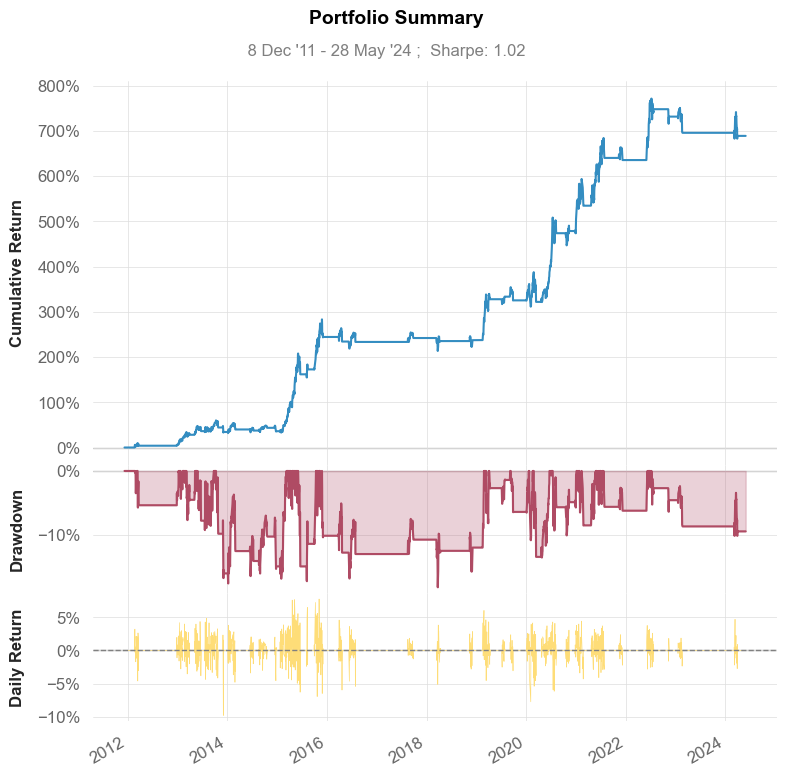

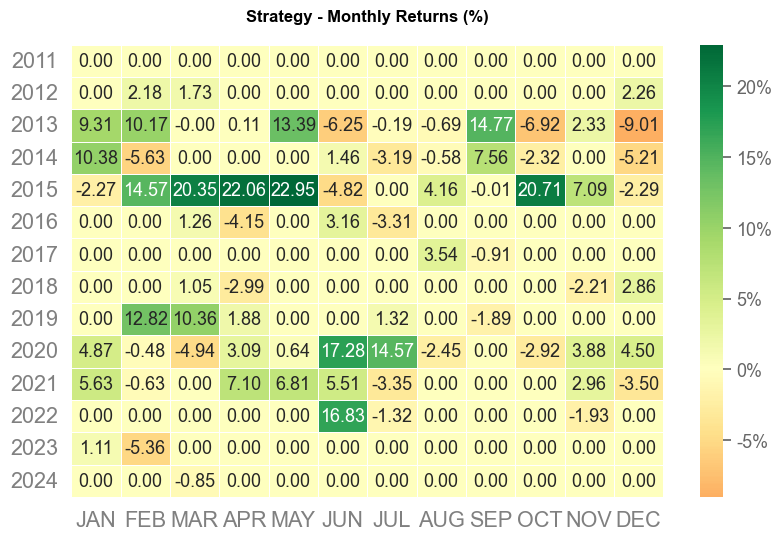

In [22]:
# quantstats分析
import quantstats as qs
qs.reports.basic(returns)